In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

from pycalphad import Database, equilibrium, calculate, binplot, Model
from pycalphad import variables as v
from pycalphad.plot.utils import phase_legend


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.1


### Generating data

In [3]:
alsi = "tdbs/AlSi-97Feu-LB.tdb"

In [4]:
# Define the thermodynamic database
db = Database(alsi)

# Set the conditions
pressure = 101325  # Pa
elements = ['AL', 'SI', 'VA']
compositions = {"AL": 0.5, "SI": 0.5}  # Composition of the material
temperature_range = range(500, 1500, 10)  # Temperature range to plot, 100 points

conditions = {v.X('SI'):0.5, v.P: pressure, v.T: temperature_range, v.N: 1}
eq = equilibrium(db, elements, 'FCC_A1', conditions, output='GM')
    
# Calculate the Gibbs energy at each temperature
# gibbs_energy = [] 
# for temperature in temperature_range:
#     result = calculate(db, elements, 'FCC_A1', P=pressure, T=temperature, output='GM')
#     gibbs_energy.append(result.GM[0][0])  # Convert the NumPy scalar to a Python float
    
temperature_range = np.array(temperature_range)
gibbs_energy = [i[0] for i in eq.GM[0][0]]

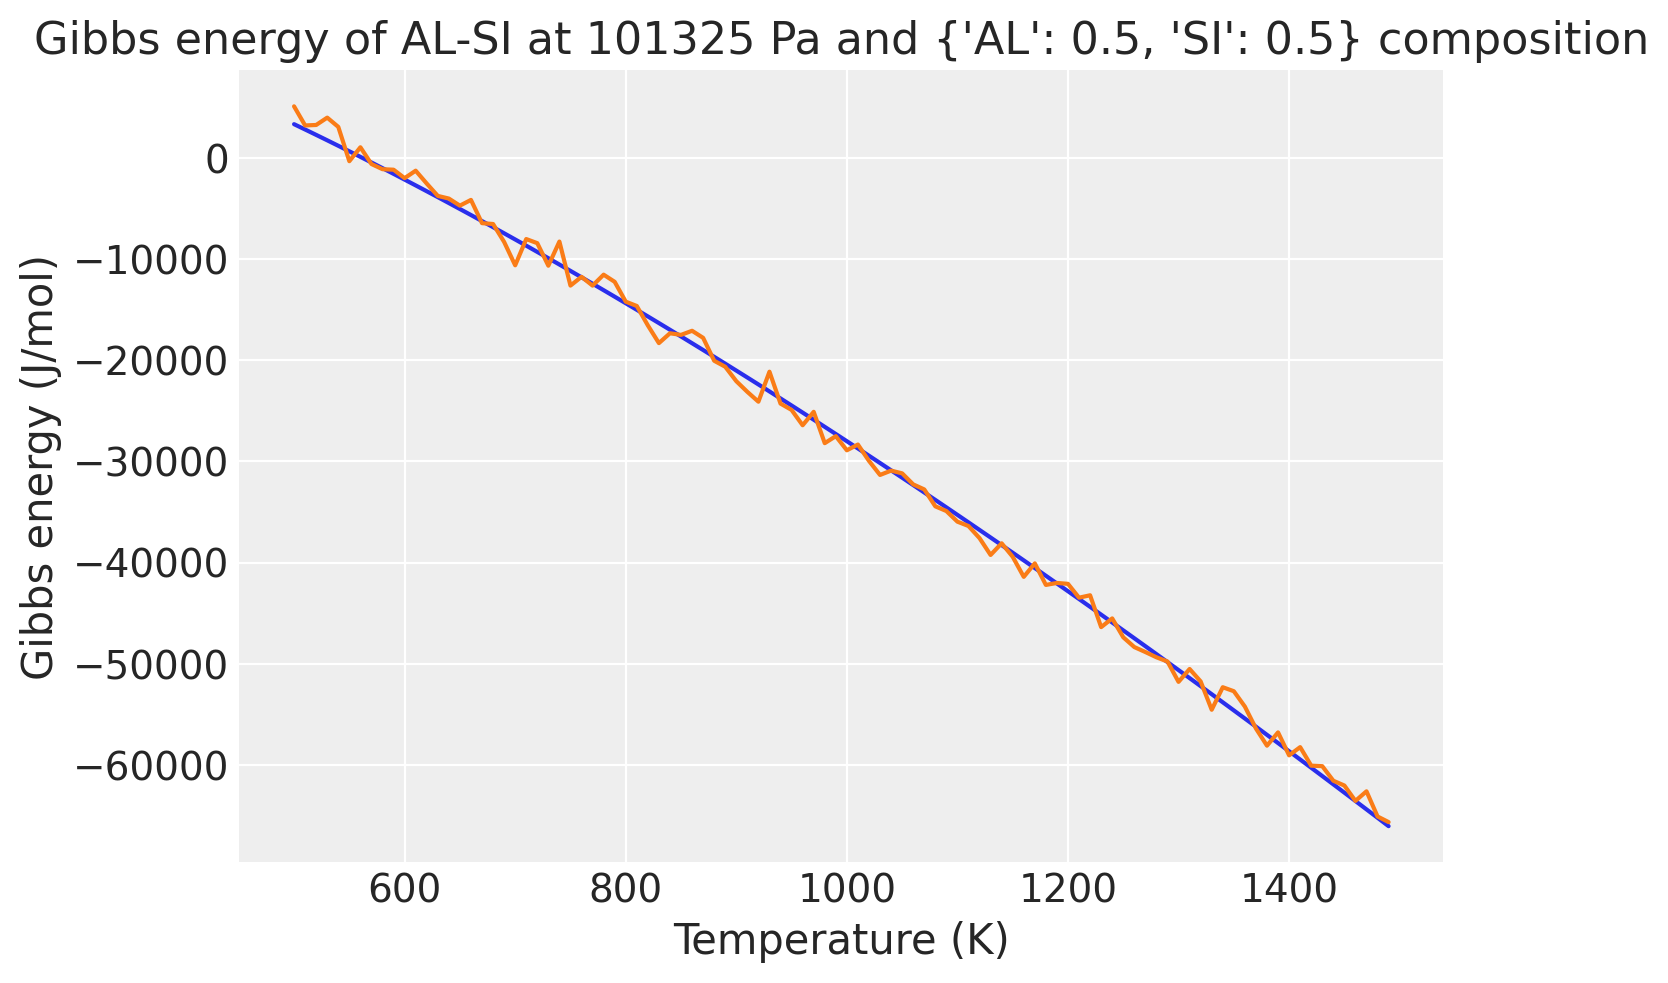

In [5]:
# Make a copy of the Gibbs energy with a little distribution
np.random.seed(0)  # Set the random seed for reproducibility
gibbs_energy_disturbed = gibbs_energy  + np.random.normal(0, 1000, len(gibbs_energy))

# Plot the original and disturbed data
plt.plot(temperature_range, gibbs_energy, label='Original data')
plt.plot(temperature_range, gibbs_energy_disturbed, label='Disturbed data with noise')
plt.xlabel('Temperature (K)')
plt.ylabel('Gibbs energy (J/mol)')
plt.title('Gibbs energy of AL-SI at {} Pa and {} composition'.format(pressure, compositions))

# Show the plot
plt.show()

### Model Specification

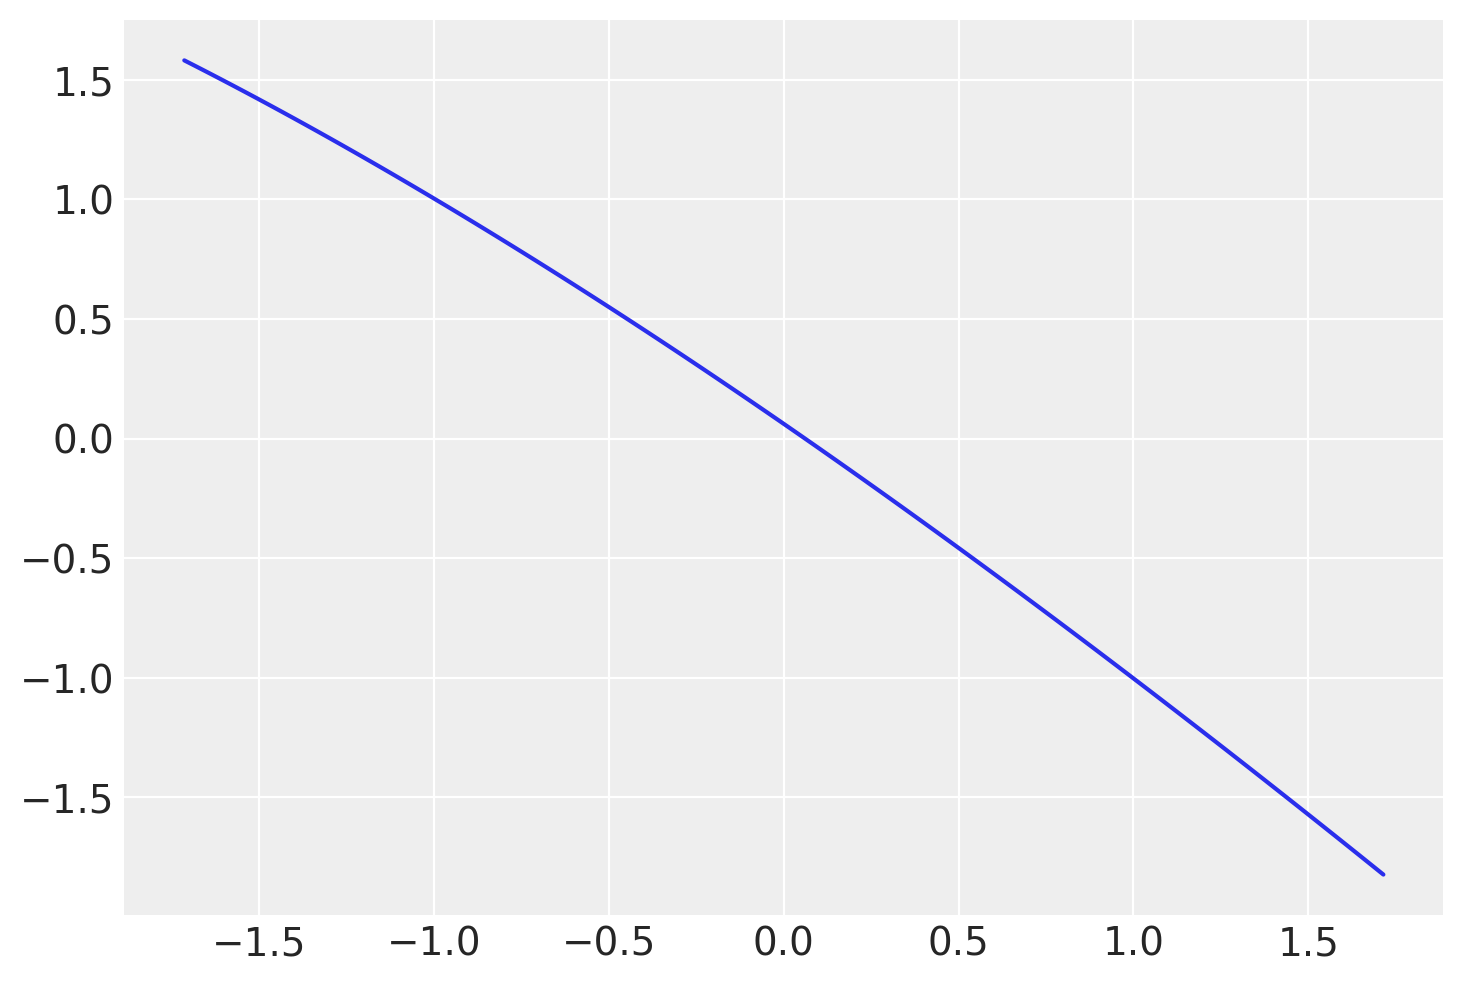

In [7]:
import numpy as np
from sklearn.preprocessing import scale
y_emp = gibbs_energy      # empirical evidance y
x_emp = temperature_range # empirical evidance x

# Standardize the data using sklearn.preprocessing.scale
x_standardized = scale(x_emp)
y_standardized = scale(y_emp)

plt.plot(x_standardized, y_standardized, label='Original data')

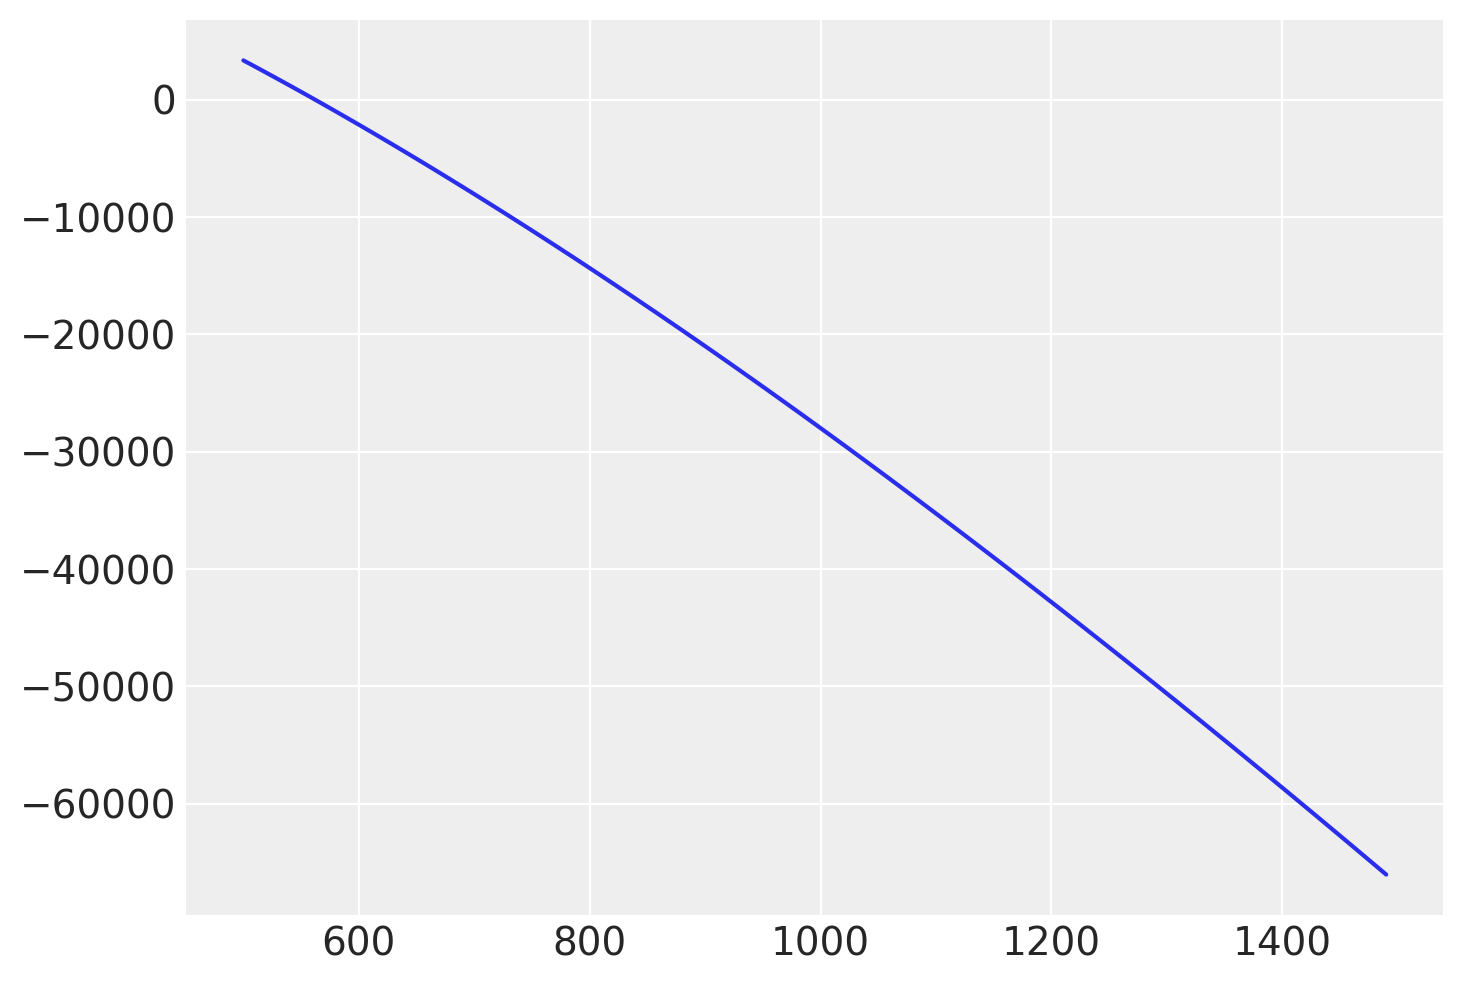

In [8]:
# Plot the original and disturbed data
plt.plot(temperature_range, y_emp, label='Original data')
# plt.plot(temperature_range, gibbs_energy_disturbed, label='Disturbed data with noise')
# plt.xlabel('Temperature (K)')
# plt.ylabel('Gibbs energy (J/mol)')
# plt.title('Gibbs energy of AL-SI at {} Pa and {} composition'.format(pressure, compositions))

# Show the plot
plt.show()

In [9]:
basic_model = pm.Model()  # create pymc3 model object

with basic_model:         # in this model context define its parameters
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=20)        # normal distribution of alpha parameter with E = 0, and sigma = 20
    beta = pm.Normal("beta", mu=0, sigma=20) # normal distribution of 2d beta parameter with E = 0, and sigma = 20
    sigma = pm.HalfNormal("sigma", sigma=20)           # halfnormal distribution of sigma - random disturbance (standart estimate)

    # Expected value of outcome
    mu = alpha + beta * x_standardized # predictions

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_standardized) # model likelihood 

In [10]:
with basic_model:
    # draw 1000 posterior samples
    trace_bm =  pm.sample(1000, chains=2, tune=1000, step = pm.NUTS())

c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.


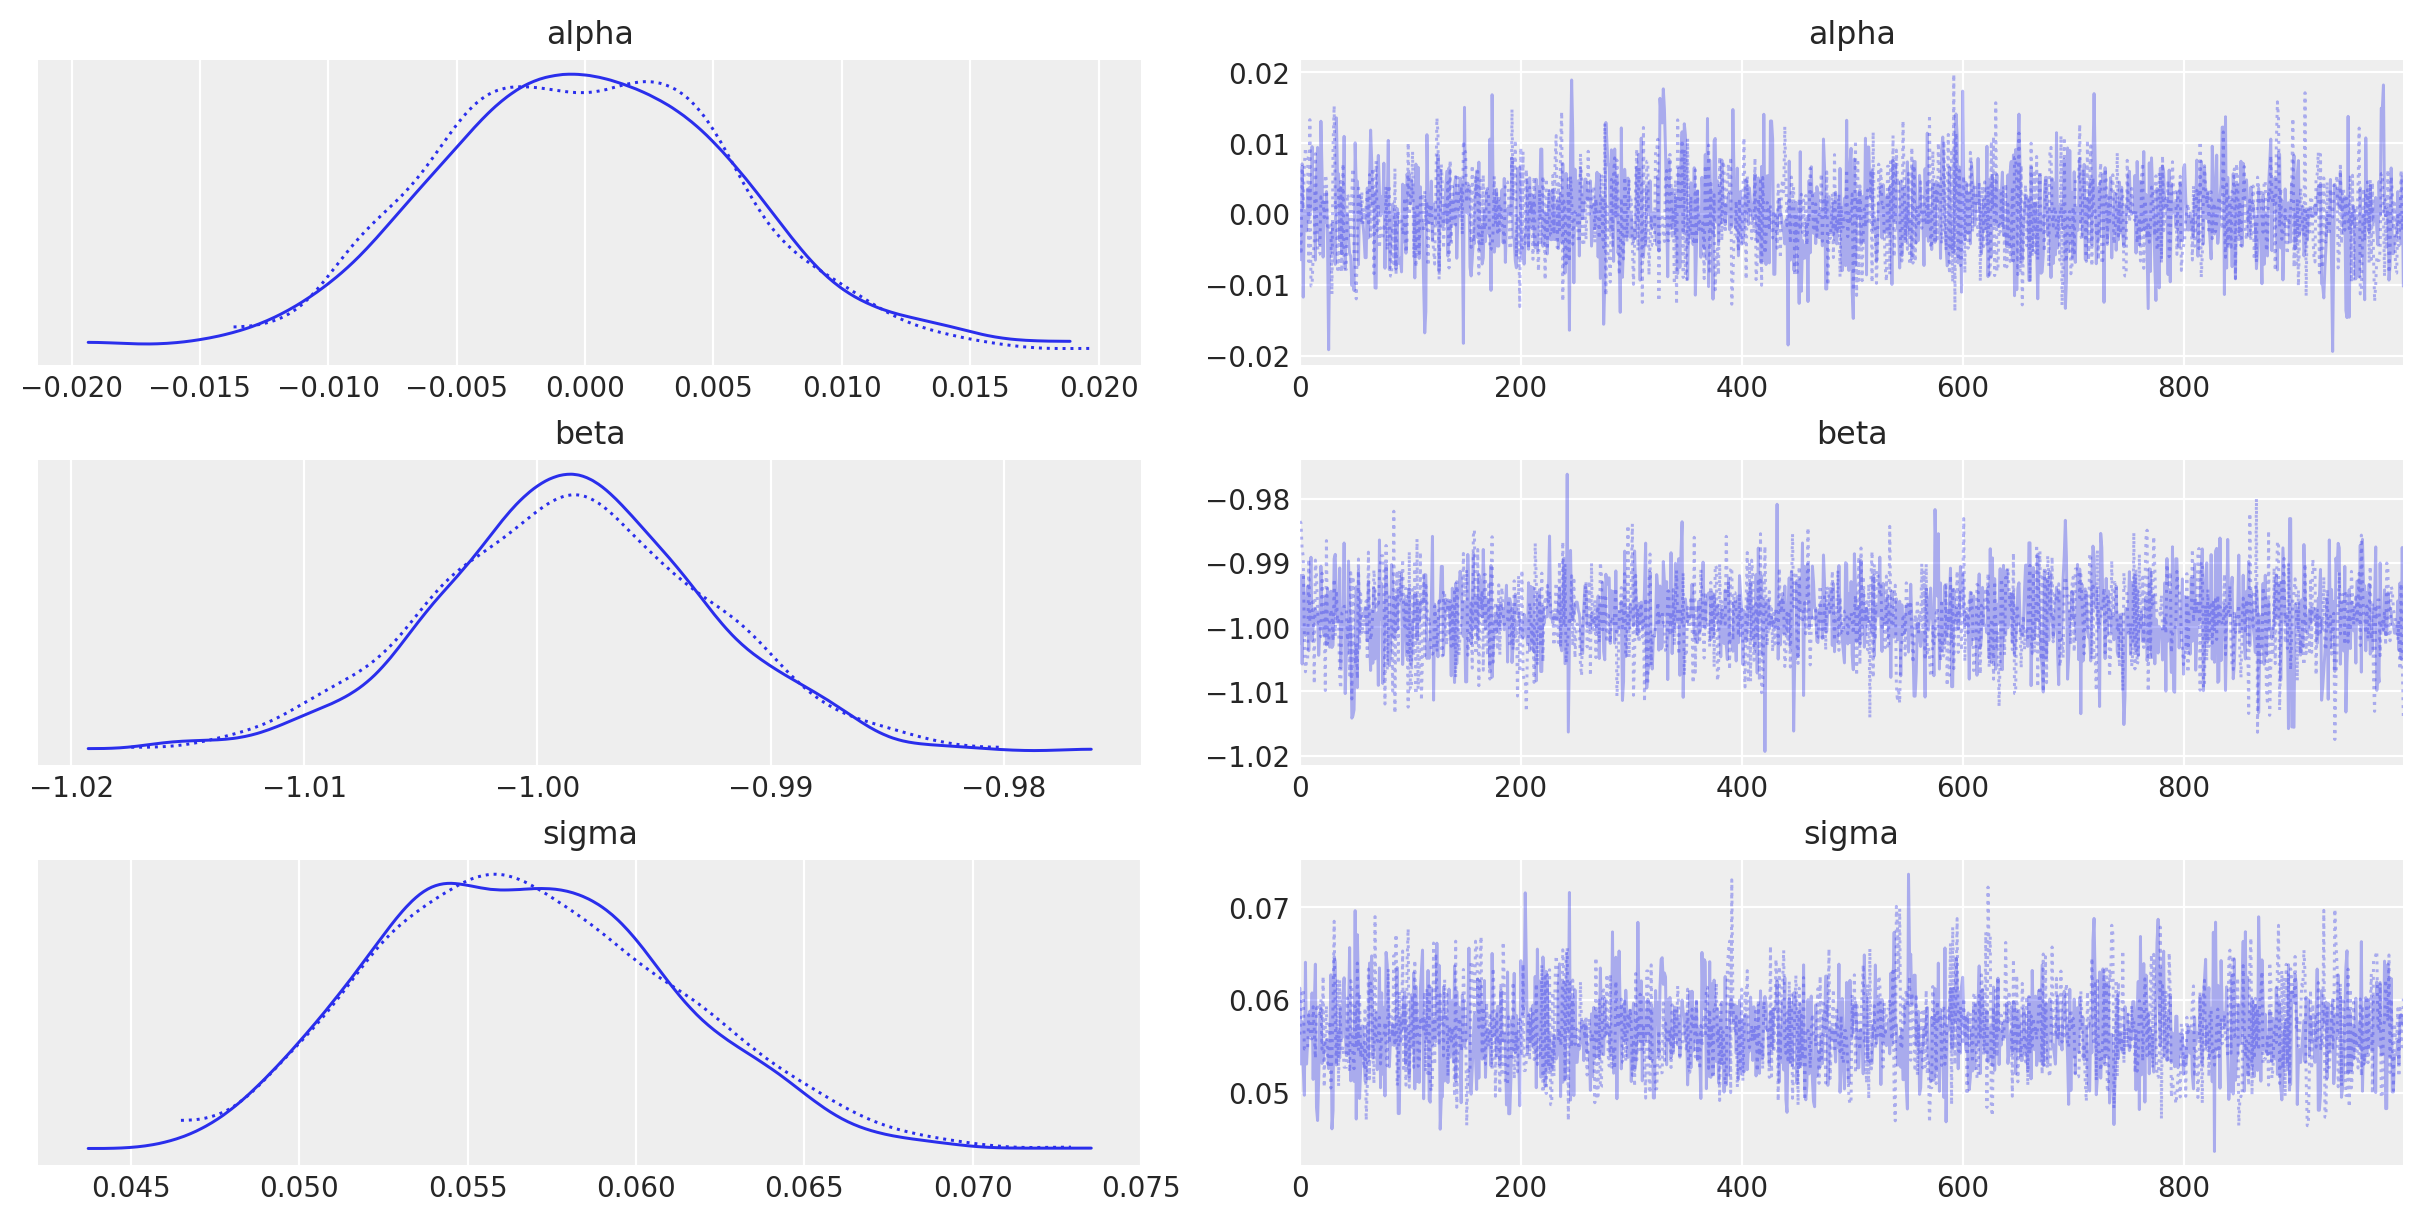

In [11]:
with basic_model:
    az.plot_trace(trace_bm);

(array([  8.,  88., 277., 488., 491., 355., 198.,  71.,  19.,   5.]),
 array([0.04370284, 0.04668773, 0.04967262, 0.05265751, 0.0556424 ,
        0.0586273 , 0.06161219, 0.06459708, 0.06758197, 0.07056686,
        0.07355175]),
 <BarContainer object of 10 artists>)

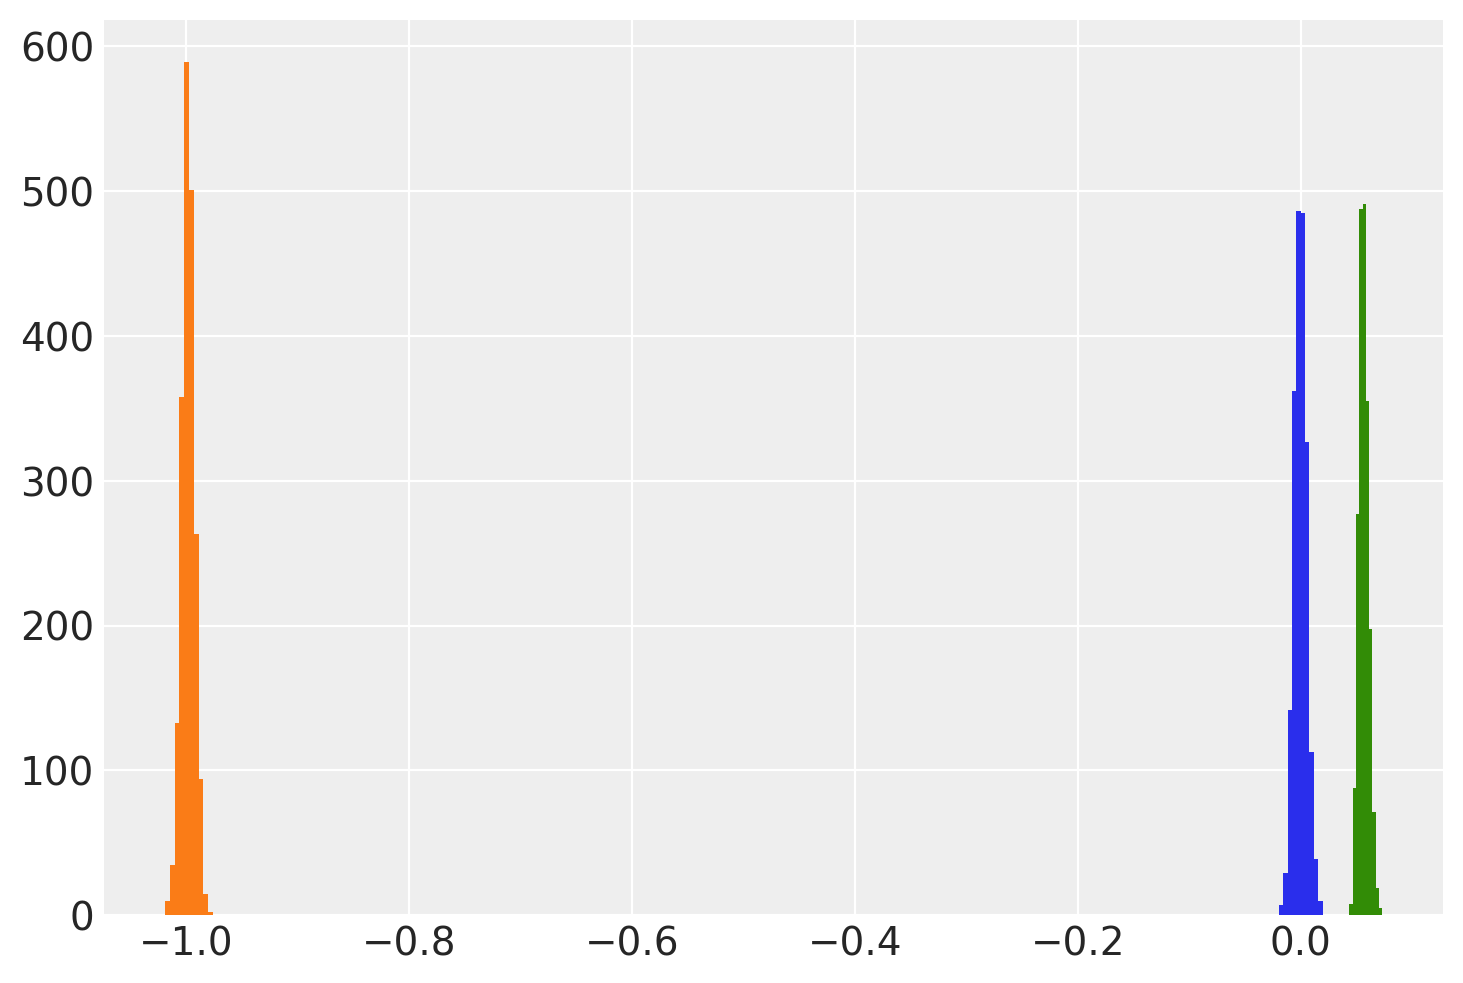

In [12]:
plt.hist(trace_bm[alpha])
plt.hist(trace_bm[beta])
plt.hist(trace_bm[sigma])

In [14]:
with basic_model:
    display(az.summary(trace_bm, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.01,-0.01,0.01,0.0,0.0,2356.01,1373.43,1.0
beta,-1.00,0.01,-1.01,-0.99,0.0,0.0,2504.98,1335.07,1.0
sigma,0.06,0.00,0.05,0.07,0.0,0.0,2157.91,1330.02,1.0


In [15]:
import pymc3 as pm
import numpy as np

# Define data and model parameters
n = 100  # Number of data points
x = np.random.randn(n)  # Input data
true_slope = 0.5  # True slope of line
true_intercept = 1.0  # True y-intercept of line
noise = 0.1 * np.random.randn(n)  # Noise added to output
y = true_slope * x + true_intercept + noise  # Output data

# Define prior distributions for model parameters
with pm.Model() as model:
    # Slope and intercept of line
    slope = pm.Normal('slope', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    # Noise parameter (standard deviation of noise)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define likelihood function
    likelihood = pm.Normal('y', mu=slope * x + intercept, sigma=sigma, observed=y)

    # Sample from posterior distribution
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


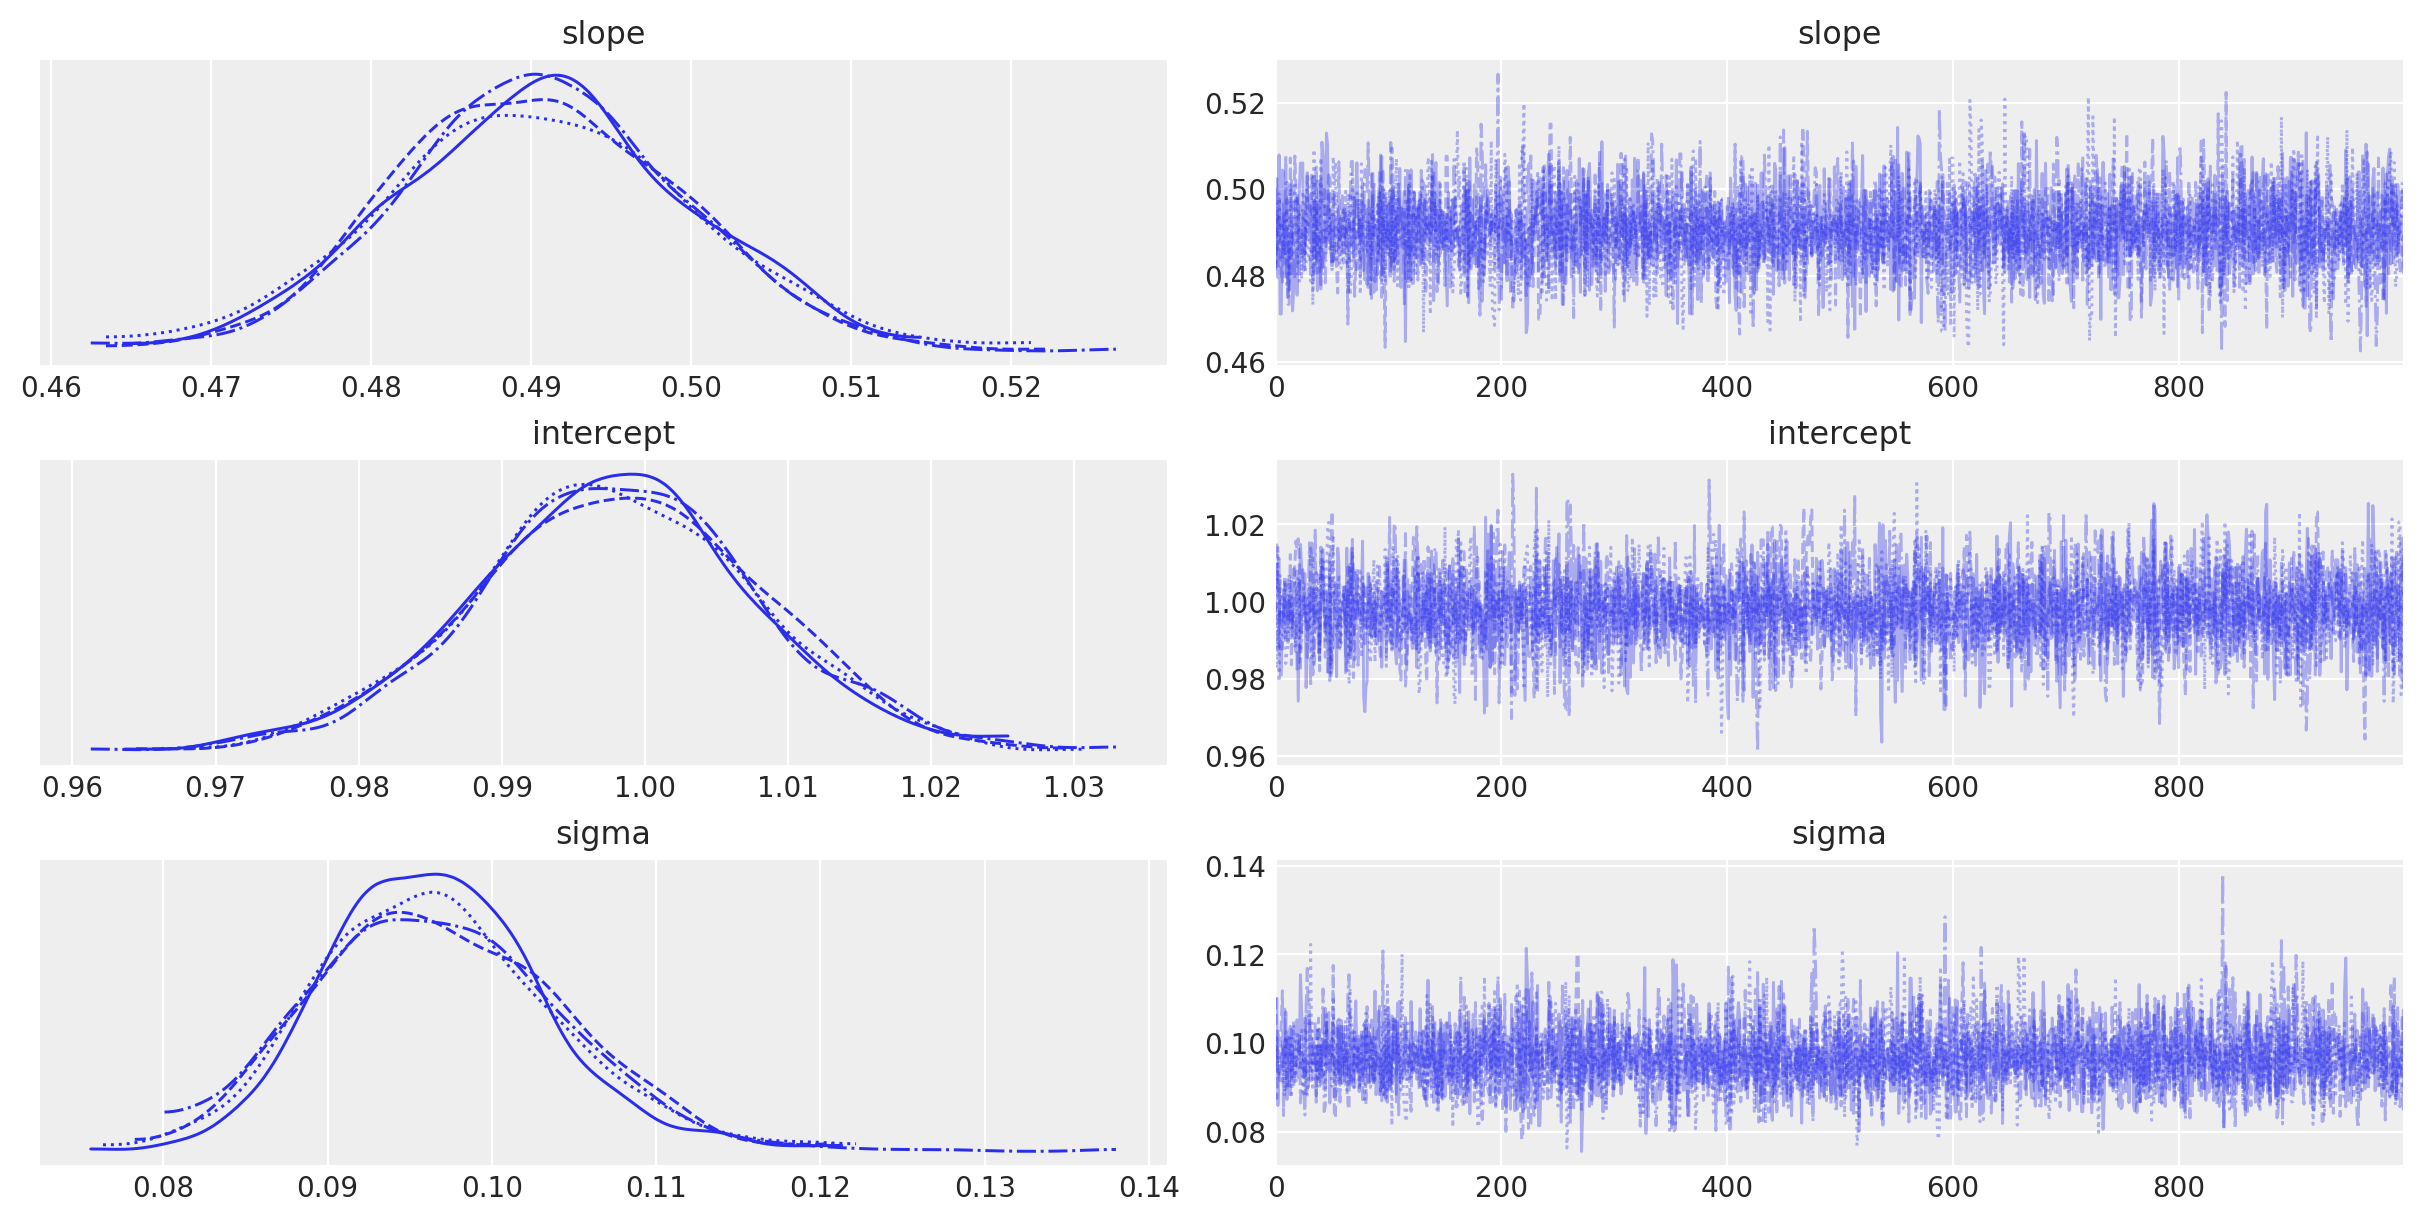

In [16]:
with model:
    az.plot_trace(trace);